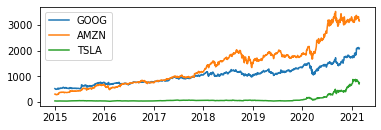

In [1]:
#Portfolio Analysis 
import pandas as pd
from pandas_datareader import wb
from datetime import datetime
from datetime import date
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols
import numpy as np
from math import log, sqrt
import random
from scipy.optimize import minimize
from scipy.stats import norm
import pandas_datareader as pdr
import math
import openpyxl
import scipy
import scipy.linalg 

start = datetime(2015, 1, 1)
end = date.today()
bono = web.DataReader('T10Y2Y', 'fred', start, end)
tickers = ['GOOG','AMZN','TSLA']
data = web.get_data_yahoo(tickers, start, end)['Adj Close']
data= data.fillna(method='bfill', limit=1)


goog=data['GOOG']
amzn = data['AMZN']
tsla = data['TSLA']


plt.subplot(2,1,1)
plt.plot(goog)
plt.plot(amzn)
plt.plot(tsla)

plt.legend(['GOOG', 'AMZN','TSLA'])



In [2]:
#get returns
def calculate_log_return(start_price, end_price):
    return log(end_price/start_price)
  
def get_returns(prices):
    returns = []
    for i in range(len(prices)-1):
        start_price = prices[i]
        end_price = prices[i+1]
        returns.append(calculate_log_return(start_price,end_price))
    return returns

r_goog = get_returns(goog)
r_amzn = get_returns(amzn)
r_tsla = get_returns(tsla)


log_ret = pd.DataFrame()
log_ret['goog'] =r_goog
log_ret['amzn'] =r_amzn
log_ret['tsla'] =r_tsla

log_ret.dropna()


,goog,amzn,tsla
0,-0.021066,-0.020731,-0.042950
1,-0.023450,-0.023098,0.005648
2,-0.001715,0.010544,-0.001563
3,0.003148,0.006813,-0.001566
4,-0.013035,-0.011818,-0.018981
...,...,...,...
1541,-0.005234,0.005903,-0.013586
1542,-0.007614,-0.023816,-0.007752
1543,-0.017408,-0.021510,-0.089376
1544,0.002892,0.004317,-0.022161


In [38]:
num_ports = 10000
num_columns = log_ret.shape[1]
all_weights = np.zeros((num_ports, num_columns))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)
risk_free=0.12

for x in range(num_ports):
    weights = np.random.random(num_columns)
    weights = weights/np.sum(weights)
    all_weights[x,:] = weights
    ret_arr[x] = np.sum( (np.mean(log_ret, axis=0) * weights * 252))
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(np.cov(log_ret, rowvar=False)*252, weights)))
    sharpe_arr[x] = (ret_arr[x] - risk_free)/ vol_arr[x]

max_value = sharpe_arr.max()
max_value_pos = sharpe_arr.argmax()

print(f"""
máx Sharpe rate: {max_value}
Posición en el array: {max_value_pos}
""")

print("Activos:  GOOG, AMZN, TSLA")
print(f""" 
Pesos: {all_weights[max_value_pos, :]}
""")



máx Sharpe rate: 0.9085846717190544
Posición en el array: 2185

Activos:  GOOG, AMZN, TSLA
 
Pesos: [0.00224279 0.7956126  0.20214461]



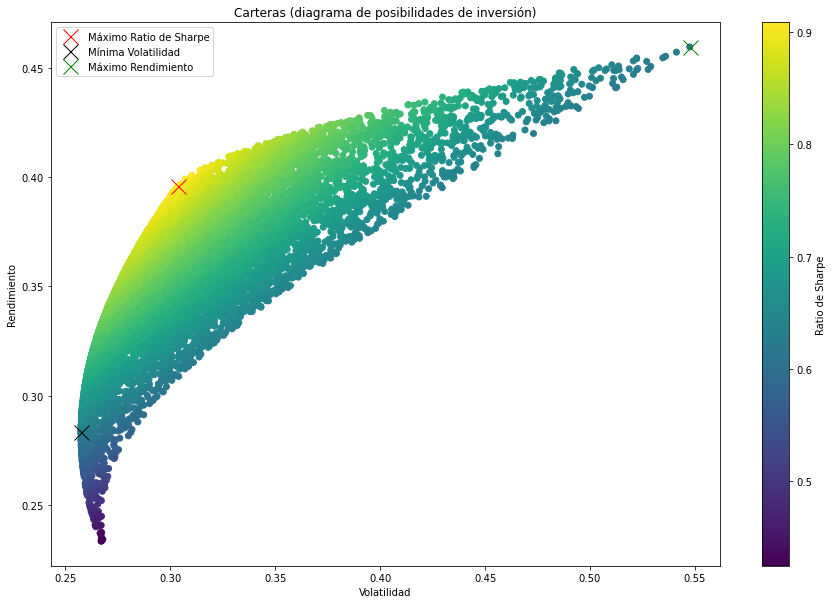

In [4]:
#Max r, Min risk, Max Sharpe rate
max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol = vol_arr[sharpe_arr.argmax()]
max_ret_ret = ret_arr[ret_arr.argmax()]
max_ret_vol = vol_arr[ret_arr.argmax()]
min_vol_ret = ret_arr[vol_arr.argmin()]
min_vol_vol = vol_arr[vol_arr.argmin()]


plt.figure(figsize=(15,10))
plt.title('Carteras (diagrama de posibilidades de inversión)')
plt.scatter(x=vol_arr, y=ret_arr, c=sharpe_arr) 
plt.colorbar(label='Ratio de Sharpe')
plt.xlabel('Volatilidad')
plt.ylabel('Rendimiento')
plt.plot(max_sr_vol, max_sr_ret, 'rx', markersize=15, label="Máximo Ratio de Sharpe")
plt.plot(min_vol_vol, min_vol_ret, 'kx', markersize=15, label="Mínima Volatilidad")
plt.plot( max_ret_vol,max_ret_ret, 'gx', markersize=15, label="Máximo Rendimiento")

plt.legend()
plt.show()


In [20]:
#Portfolio t 
pesos = all_weights[max_value_pos, :]
STOCK_CAP = 100000
precio_t = data.iloc[-1,:]
precio_t
q_stock = (STOCK_CAP*pesos)/precio_t
np.set_printoptions(suppress = True)
q_stock = np.floor(q_stock)
portfolio_t = pd.DataFrame()
portfolio_t['Acciones'] = q_stock
portfolio_t['Precio'] = precio_t
portfolio_t['Valor'] = q_stock* precio_t
portfolio_t
valor_portfolio = sum(portfolio_t['Valor'])
portfolio_t['r_m'] = [np.mean(get_returns(goog)),np.mean(get_returns(amzn)),np.mean(get_returns(tsla))]
portfolio_t['std'] =[np.std(get_returns(goog)),np.std(get_returns(amzn)),np.std(get_returns(tsla))]
portfolio_t


,Acciones,Precio,Valor,r_m,std
Symbols,,,,,
GOOG,0.0,2095.169922,0.000000,0.000897,0.016996
AMZN,25.0,3159.530029,78988.250732,0.001505,0.019299
TSLA,27.0,742.020020,20034.540527,0.001829,0.034757


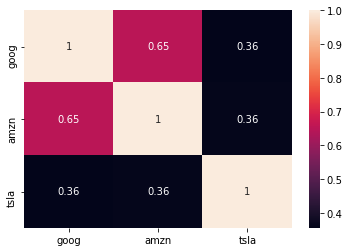

In [21]:
#Monte Carlo simulation VaR
import scipy
import scipy.linalg
import seaborn as sns

correlation_mat = log_ret.corr()
sns.heatmap(correlation_mat, annot = True)

plt.show()

correlation_mat
L = scipy.linalg.cholesky(correlation_mat, lower=True)
U = scipy.linalg.cholesky(correlation_mat, lower=False)


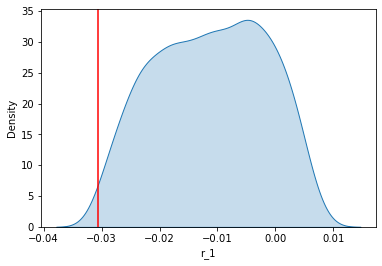

In [37]:
df_sim = pd.DataFrame() 
df_sim['acc1']=np.random.normal(0,1,1000)
df_sim['acc2']=np.random.normal(0,1,1000)
df_sim['acc3']=np.random.normal(0,1,1000)


df_sim= np.dot(df_sim,U)

#df = pd.DataFrame()

port_sim = pd.DataFrame()
port_sim['goog'] = np.exp(df_sim[:,0]*portfolio_t['std'][0])*portfolio_t['Precio'][0]
port_sim['amzn'] = np.exp(df_sim[:,1]*portfolio_t['std'][1])*portfolio_t['Precio'][1]
port_sim['tsla'] = np.exp(df_sim[:,2]*portfolio_t['std'][2])*portfolio_t['Precio'][2]

port_sim ['q_goog'] = np.floor((STOCK_CAP*pesos[0])/df['goog'])
port_sim ['q_amzn'] = np.floor((STOCK_CAP*pesos[1])/df['amzn'])
port_sim ['q_tsla'] = np.floor((STOCK_CAP*pesos[2])/df['tsla'])
port_sim ['v_1'] = (port_sim ['q_goog']*df['goog']) + (port_sim ['q_amzn'] * df['amzn'])+(port_sim ['q_tsla']*df['tsla'])
port_sim ['r_1'] = np.log(port_sim ['v_1']/valor_portfolio)
var_mc_corr = np.percentile(port_sim ['r_1'], 0.05)
var_mc_corr

sns.kdeplot(port_sim ['r_1'],shade=True)

plt.axvline(var_mc_corr,0, color = "r",  linestyle = "-" )
plt.show()